In [2]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt

# For topological data analysis (TDA)
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy

# Ensure plots are displayed inline
%matplotlib inline

In [3]:
def plot_persistence_diagrams_custom(diagram, dimensions=[0, 1, 2]):
    if len(dimensions) < 1:
        print("No dimensions specified for plotting.")
        return
    
    num_dims = len(dimensions)
    fig, axes = plt.subplots(1, num_dims, figsize=(5 * num_dims, 4))
    
    if num_dims == 1:
        axes = [axes]
    
    for i, dim in enumerate(dimensions):
        ax = axes[i]
        diag_dim = diagram[diagram[:, 2] == dim]
        if diag_dim.size == 0:
            ax.set_title(f"No features for dimension {dim}")
            ax.set_xlabel("Birth")
            ax.set_ylabel("Death")
            continue
        
        births = diag_dim[:, 0]
        deaths = diag_dim[:, 1]
        
        ax.scatter(births, deaths, alpha=0.7, label=f"Dim {dim}")
        
        min_val = min(births.min(), deaths.min())
        max_val = max(births.max(), deaths.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--')
        
        ax.set_title(f"Persistence Diagram (dim={dim})")
        ax.set_xlabel("Birth")
        ax.set_ylabel("Death")
        ax.legend()
    
    plt.tight_layout()
    plt.show()


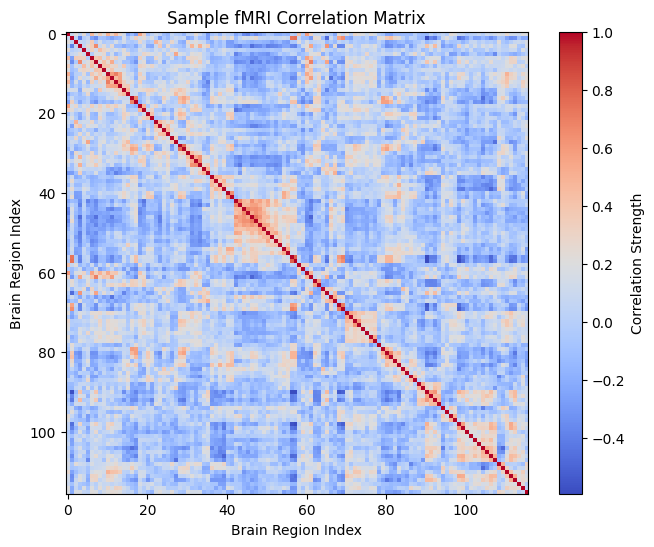

In [4]:
sample_file = "./abide/sub-control50030/sub-control50030_AAL116_correlation_matrix.mat"
mat_data = sio.loadmat(sample_file)
correlation_matrix = mat_data['data']

plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation Strength')
plt.title("Sample fMRI Correlation Matrix")
plt.xlabel("Brain Region Index")
plt.ylabel("Brain Region Index")
plt.show()



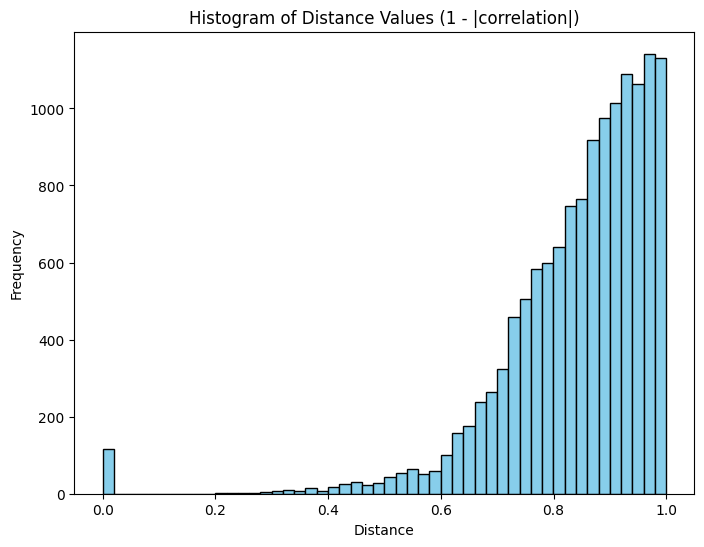

In [5]:
distance_matrix = 1 - np.abs(correlation_matrix)

plt.figure(figsize=(8, 6))
plt.hist(distance_matrix.flatten(), bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Distance Values (1 - |correlation|)")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()




In [6]:
tda = VietorisRipsPersistence(metric="precomputed", homology_dimensions=[0, 1, 2])
diagrams = tda.fit_transform([distance_matrix])

print("Shape of persistence diagrams:", diagrams.shape)
print("Sample diagram data:\n", diagrams[0][:5], "...")

Shape of persistence diagrams: (1, 447, 3)
Sample diagram data:
 [[0.         0.20292941 0.        ]
 [0.         0.23221581 0.        ]
 [0.         0.25198781 0.        ]
 [0.         0.28208658 0.        ]
 [0.         0.29058877 0.        ]] ...


/home/hice1/crunch40/.jupyterhub/lib64/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/hice1/crunch40/.jupyterhub/lib64/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


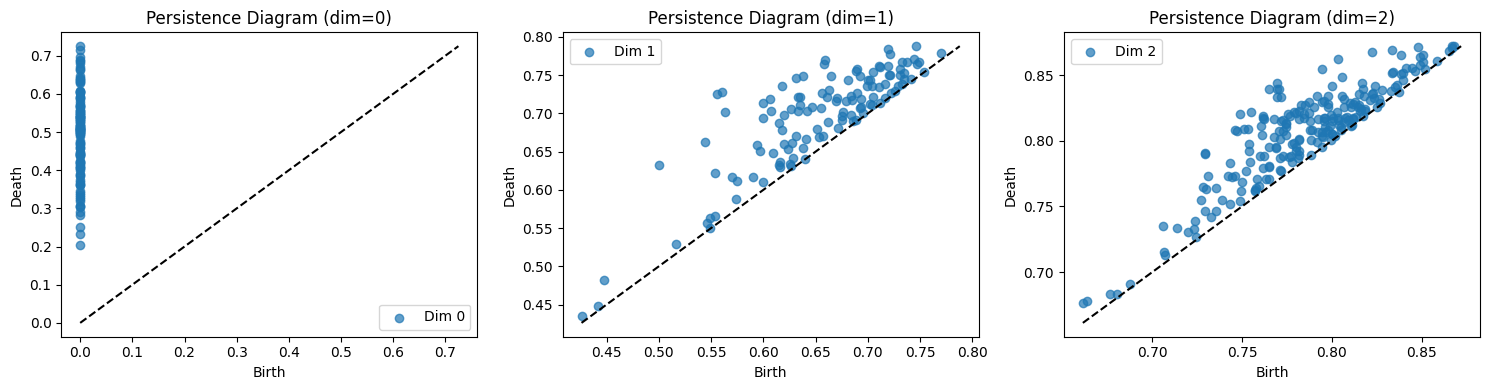

In [7]:
plot_persistence_diagrams_custom(diagrams[0], dimensions=[0, 1, 2])


Computed Persistence Entropy: [6.80710847 6.40034179 7.27828364]


/home/hice1/crunch40/.jupyterhub/lib64/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/hice1/crunch40/.jupyterhub/lib64/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


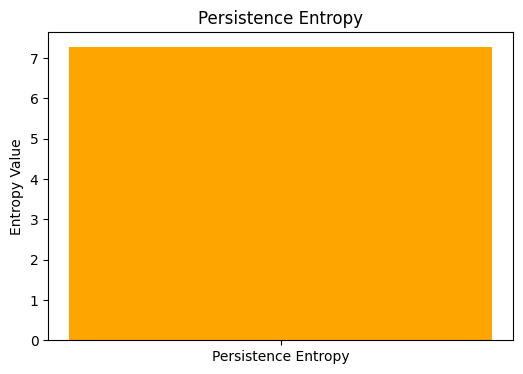

In [8]:
entropy = PersistenceEntropy().fit_transform(diagrams)
entropy_value = entropy.flatten()
print("Computed Persistence Entropy:", entropy_value)

plt.figure(figsize=(6, 4))
plt.bar(['Persistence Entropy'], entropy_value, color='orange')
plt.title("Persistence Entropy")
plt.ylabel("Entropy Value")
plt.show()


In [ ]:
DATA_DIR = "./abide"
OUTPUT_CSV = "tda_features_overall.csv"

subject_dirs = [os.path.join(DATA_DIR, d) for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
all_features = []

for subject_dir in subject_dirs:
    subject_id = os.path.basename(subject_dir)
    file_list = [f for f in os.listdir(subject_dir) if "AAL116_correlation_matrix.mat" in f]
    
    for filename in file_list:
        file_path = os.path.join(subject_dir, filename)
        try:
            data = sio.loadmat(file_path)
            corr_matrix = data['data']
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            continue
        
        dist_matrix = 1 - np.abs(corr_matrix)
        tda = VietorisRipsPersistence(metric="precomputed", homology_dimensions=[0, 1, 2])
        pers_diagrams = tda.fit_transform([dist_matrix])
        
        entropy_val = PersistenceEntropy().fit_transform(pers_diagrams)

        all_features.append([subject_id, filename] + entropy_val.flatten().tolist())

if all_features:
    num_entropy = len(all_features[0]) - 2
    columns = ["Subject_ID", "File_Name"] + [f"TDA_Feature_{i}" for i in range(num_entropy)]
    feature_df = pd.DataFrame(all_features, columns=columns)
    feature_df.to_csv(OUTPUT_CSV, index=False)
    print(f"Saved TDA features to {OUTPUT_CSV}")
else:
    print("No TDA features were extracted from the dataset.")

In [10]:
if 'feature_df' in globals() and not feature_df.empty and "TDA_Feature_0" in feature_df.columns:
    plt.figure(figsize=(8, 6))
    plt.hist(feature_df["TDA_Feature_0"], bins=30, color='green', edgecolor='black')
    plt.title("Distribution of Persistence Entropy (TDA_Feature_0)")
    plt.xlabel("Persistence Entropy")
    plt.ylabel("Number of Subjects")
    plt.show()
else:
    print("Persistence entropy data not available for plotting.")


Persistence entropy data not available for plotting.
